In [46]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt

# Dataframe columns
The following dataframe has columns which do have the following meaning:
 
0. Frequency (in THz). This is the **independent variable** which is influencing the overall procedure. 

1. Wavelength (in nm, can be directly derived from frequency of course).

2. Intensity (defined as the **metric of interest**, intensity is very significant for this analysis). Please consider that the square root of the intensity can be analysed as the Electric Field. 

3. Phase (between minus and plus infinity).

4. **Phase cutted** (with respect to those frequencies corresponding to values of intensity equal to zero).

In [47]:
file_name = "LLNL_160809_freq.csv"
df = pd.read_csv("data/"+file_name, header = None)
df.columns = ["Frequency", "Wavelength", "Intensity", "Phase", "Phase (cutted)"] 
df.describe()

,Frequency,Wavelength,Intensity,Phase,Phase (cutted)
count,1027.000000,1027.000000,1027.000000,1027.000000,1027.000000
mean,388.703722,797.636767,0.077578,-335.902940,0.007874
std,69.084920,147.503173,0.218707,541.012492,0.212221
min,269.220000,590.333000,0.000000,-2491.000000,-1.196000
25%,328.961500,668.977500,0.000000,-312.586500,0.000000
50%,388.704000,771.796000,0.000000,-179.213000,0.000000
75%,448.445500,911.960000,0.000000,-7.072500,0.000000
max,508.188000,1114.331000,1.000000,350.355000,1.373000


Considering now the purposes of this analysis, it is clear that in this case it is possible to discard some columns from consideration. Such columns are *phase* (since the cutted version is preferred) and *wavelength* (which can also be obtained, if needed considering the very index of the dataframe).

In [48]:
try: 
    df.drop(columns = ["Wavelength", "Phase"], inplace = True)
except KeyError: 
    pass

# selecting only the interesting elements for the analysis
frequency = df.loc[:, "Frequency"].values
intensity = df.loc[:, "Intensity"].values
electric_field = np.sqrt(intensity)

The upcoming `fft` algorithm requires the input frequencies to be equidistant (~constant value for np.diff), but the control system does not allow such a strategy, therefore it is important to obtain a way with which to approximate intensity (and electric field) directly from frequency values. 
To do so, rbf-kernellized regression will be used. 

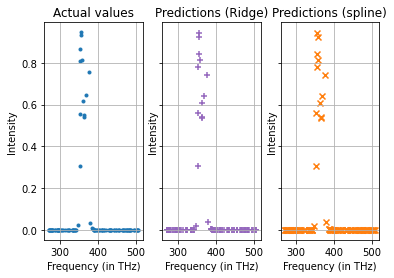

RBF-Kernel Ridge MSE: 1.8803085026187923e-05
Training time: 0.121 s
Inference time: 0.002 s
Spline MSE: 7.707170367077678e-06
(interpolation) Training time: 0.000 s
(interpolation) Inference time: 0.002 s


In [49]:
from sklearn.kernel_ridge import KernelRidge
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import make_pipeline
from scipy.interpolate import interp1d, UnivariateSpline
import time

# setting a random state
rs = 7

# building a model that infers intensity from frequency
Xtrain, Xtest, ytrain, ytest = train_test_split(frequency.reshape(-1,1), intensity, test_size=0.1, random_state=rs)

# using kernel Ridge given the high non linearity of the function considered
model_intensity = make_pipeline(KernelRidge(alpha = 5e-2, kernel = "rbf"))

start_time = time.time()
model_intensity_interp = interp1d(Xtrain.reshape(-1,), ytrain)
interp_time = time.time() - start_time

start_time = time.time()
model_intensity.fit(Xtrain, ytrain)
train_time = time.time() - start_time

start_time = time.time()
yspline = model_intensity_interp(Xtest)
inference_time = time.time() - start_time

start_time = time.time()
ypred = model_intensity.predict(Xtest)
inference_time = time.time() - start_time

fig, ax = plt.subplots(ncols = 3, sharey = True)

ax[0].scatter(Xtest, ytest, marker = ".",  c = "tab:blue", label = "Actual Points")
ax[1].scatter(Xtest, ypred, marker = "+",  c = "tab:purple", label = "Ridge Regression")
ax[2].scatter(Xtest, ypred, marker = "x",  c = "tab:orange", label = "Spline")

ax[0].set_title("Actual values")
ax[0].set_xlabel("Frequency (in THz)")
ax[0].grid()
ax[0].set_ylabel("Intensity")

ax[1].set_title("Predictions (Ridge)")
ax[1].set_xlabel("Frequency (in THz)")
ax[1].grid()
ax[1].set_ylabel("Intensity")

ax[2].set_title("Predictions (spline)")
ax[2].set_xlabel("Frequency (in THz)")
ax[2].grid()
ax[2].set_ylabel("Intensity")

plt.show()
print(f"RBF-Kernel Ridge MSE: {mean_squared_error(ytest, ypred)}")
print("Training time: {:.3f} s".format(train_time))
print("Inference time: {:.3f} s".format(inference_time))

print(f"Spline MSE: {mean_squared_error(ytest, yspline)}")
print("(interpolation) Training time: {:.3f} s".format(interp_time))
print("(interpolation) Inference time: {:.3f} s".format(inference_time))


Now that a model able to predict the intensity value for any given frequency it has been obtained it is possible to use it so as to obtain what is necessary in this case: an equidistant in frequency set of intensity in the frequency domain (to use the `fft` algorithm and translate them in the time domain). 

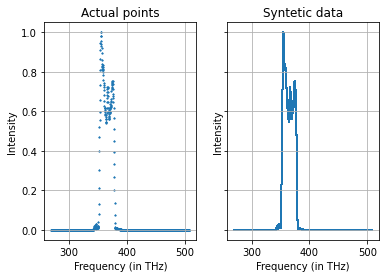

In [50]:
# The interpolation is faster and more accurate therefore regular interpolation is what it will be used
model_intensity = model_intensity_interp

# 20k value of frequency
num_points = int(2e4)
frequency_spaced = np.linspace(frequency.min(), frequency.max(), num_points)
intensity_spaced = model_intensity(frequency_spaced)

fig, ax = plt.subplots(ncols = 2, sharey = True)

ax[0].scatter(frequency, intensity, marker = "*", s = 2)
ax[0].set_title("Actual points")
ax[0].set_xlabel("Frequency (in THz)")
ax[0].set_ylabel("Intensity")
ax[0].grid()

ax[1].scatter(frequency_spaced, intensity_spaced, marker = "+", s = 2)
ax[1].set_title("Syntetic data")
ax[1].set_xlabel("Frequency (in THz)")
ax[1].set_ylabel("Intensity")
ax[1].grid()

While the second plot in the upper figure might look as a continous line, it is important to note that it is indeed a scatter plot. The reason why it looks continous is that the number of proposed points is equal to 20'000. 

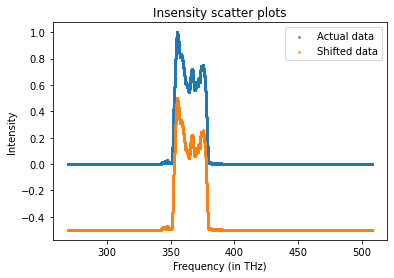

In [52]:
frequency = frequency_spaced; intensity = intensity_spaced
half_max = intensity.max()/2

shifted_intensity = intensity - half_max

fig, ax = plt.subplots()
ax.scatter(frequency, intensity, label = "Actual data", s = 2)
ax.scatter(frequency, shifted_intensity, label = "Shifted data", s = 2)

ax.set_title("Insensity scatter plots")
ax.set_xlabel("Frequency (in THz)")
ax.set_ylabel("Intensity")

ax.legend()

The orange scatter plot corresponds to the blue one, shifted downwards by half the maximal value reached. This is done so to find the frequencies corresponding to such half max since these frequencies are nothing but the *roots* of the orange curve. 

In [56]:
shifted_model = UnivariateSpline(frequency, shifted_intensity, s=0)
f1, f2 = shifted_model.roots()

Once the frequencies have been obtained it is then possible to obtain the *carrier frequency* (defined as the mean frequency between these roots). Once this is done, it is possible to extract the *angular frequency* which could then be used subsequently in a particular model used to generate the phase.

In [58]:
# carrier angular frequency - wcarrier
wcarrier = 2 * np.pi * np.abs(np.array([f1, f2])).mean()